In [1]:
import pandas as pd
import numpy as np
from generate_data import generate_data
from discrete_lognormal import DiscreteLognormal
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)
import seaborn as sns
from timeit import default_timer as timer
import warnings

In [2]:
data = generate_data()
pois = sm.Poisson(data.y, data.x_df)
pois_fit = pois.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 30.636796
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11


In [3]:
def get_loss(mod, params):
    return mod.nloglikeobs(params).mean()

true_params = np.concatenate([data.beta, data.alpha], axis=0)
def get_mse(params):
    error = params - true_params
    return np.mean(error**2)

In [4]:
n_sims = 100
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]
sim_solver_times = []
sim_losses = []
sim_mses = []
penalty = 1e-4
maxiter = 1000
n = data.y.size
tol = 1e-8 / n

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(n_sims):
        print(i)
        data = generate_data()
        times = []
        losses = []
        mses = []

        # Seed with poisson parameters
        pois = sm.Poisson(data.y, data.x_df)
        pois_fit = pois.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_fit.params
        start_params[11] = -1
        dln = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)

        start = timer()
        dln_mod = dln.fit(method = "ncg", start_params = start_params, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))

        start = timer()
        dln_mod = dln.fit(method = "cg", start_params = start_params, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))

        start = timer()
        dln_mod = dln.fit(method = "bfgs", start_params = start_params, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))

        start = timer()
        dln_mod = dln.fit(method = "powell", start_params = start_params, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        powell = end-start
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))

        start = timer()
        dln_mod = dln.fit(method = "newton", start_params = start_params, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        newton = end-start
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))
        
        start = timer()
        dln_mod = dln.fit(method = "EM", start_params=start_params, use_hessian=False, maxiter=maxiter, penalty=penalty, step_size=1e-3, tol=tol, disp=0)
        end = timer()
        newton = end-start
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))
        
        start = timer()
        dln_mod = dln.fit(method = "EM", start_params=start_params, use_hessian=True, maxiter=maxiter, penalty=penalty, tol=tol, disp=0)
        end = timer()
        newton = end-start
        times.append(end-start)
        losses.append(get_loss(dln, dln_mod.params))
        mses.append(get_mse(dln_mod.params))

        sim_solver_times.append(times)
        sim_losses.append(losses)
        sim_mses.append(mses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


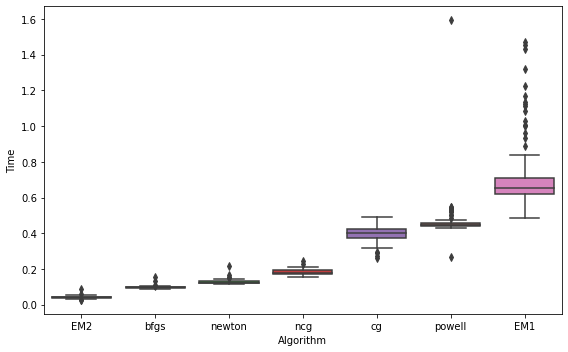

In [5]:
cols = ["ncg", "cg", "bfgs", "powell", "newton", "EM1", "EM2"]
times_df = pd.DataFrame(
    sim_solver_times,
    columns=cols)
times_long_df = pd.melt(times_df.reset_index(), id_vars="index", var_name="Algorithm" ,value_vars=cols, value_name="Time")
times_long_df = times_long_df.rename({"index": "Simulation"}, axis=1)
sns.boxplot(
    x = times_long_df.Algorithm,
    y = times_long_df.Time,
    order=["EM2", "bfgs", "newton", "ncg", "cg", "powell", "EM1"]
)
plt.tight_layout()
plt.savefig("./plots/runtimes.png")
plt.show()

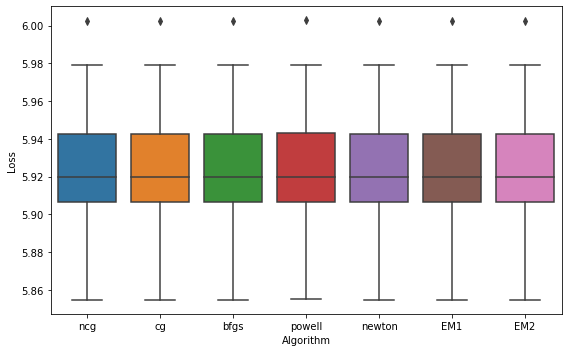

In [6]:
losses_df = pd.DataFrame(
    sim_losses,
    columns=cols)
losses_long_df = pd.melt(losses_df.reset_index(), id_vars="index", var_name="Algorithm" ,value_vars=cols, value_name="Loss")
losses_long_df = losses_long_df.rename({"index": "Simulation"}, axis=1)
sns.boxplot(
    x = losses_long_df.Algorithm,
    y = losses_long_df.Loss)
plt.tight_layout()
plt.savefig("./plots/losses.png")
plt.show()

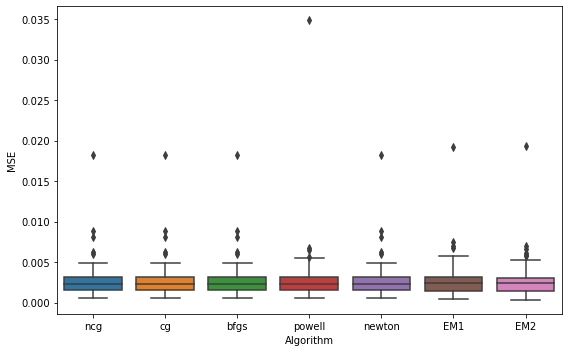

In [7]:
mses_df = pd.DataFrame(
    sim_mses,
    columns=cols)
mses_long_df = pd.melt(mses_df.reset_index(), id_vars="index", var_name="Algorithm" ,value_vars=cols, value_name="MSE")
mses_long_df = mses_long_df.rename({"index": "Simulation"}, axis=1)
sns.boxplot(
    x = mses_long_df.Algorithm,
    y = mses_long_df.MSE)
plt.tight_layout()
plt.savefig("./plots/MSE.png")
plt.show()

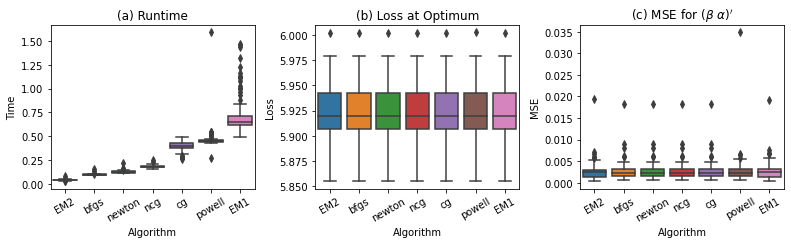

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3.5))

algorithm_order = ["EM2", "bfgs", "newton", "ncg", "cg", "powell", "EM1"]
rotate_degrees = 30
sns.boxplot(
    x = times_long_df.Algorithm,
    y = times_long_df.Time,
    order=algorithm_order,
    ax=ax[0]
)
ax[0].tick_params(axis='x', labelrotation=rotate_degrees)
ax[0].set_title("(a) Runtime")

sns.boxplot(
    x = losses_long_df.Algorithm,
    y = losses_long_df.Loss,
    order=algorithm_order,
    ax=ax[1]
)
ax[1].tick_params(axis='x', labelrotation=rotate_degrees)
ax[1].set_title("(b) Loss at Optimum")

sns.boxplot(
    x = mses_long_df.Algorithm,
    y = mses_long_df.MSE,
    order=algorithm_order,
    ax=ax[2]
)
ax[2].tick_params(axis='x', labelrotation=rotate_degrees)
ax[2].set_title(r"(c) MSE for $(\beta\ \alpha)'$")

plt.tight_layout()
fig.savefig("./plots/algorithm_comparison.png")
plt.savefig("./plots/MSE.png")
plt.show()

In [9]:
mean_times_df = times_long_df.groupby("Algorithm")["Time"].mean().reset_index()
mean_times_df = mean_times_df.rename({"Time": "Mean Runtime"}, axis=1)
mean_times_df = mean_times_df.sort_values(by="Mean Runtime")
mean_times_latex = mean_times_df.T.to_latex(
    header=False,
    float_format="{:0.3f}".format,
    bold_rows=True
)
print(mean_times_latex)

\begin{tabular}{llllllll}
\toprule
\textbf{Algorithm   } &   EM2 &  bfgs &  newton &   ncg &    cg &  powell &   EM1 \\
\textbf{Mean Runtime} & 0.042 & 0.098 &   0.125 & 0.184 & 0.397 &   0.468 & 0.723 \\
\bottomrule
\end{tabular}

